# Imports

In [149]:
import numpy as np, matplotlib.pyplot as plt, librosa as lr, librosa.display
from IPython.display import Audio

# Files Laden

In [150]:
!curl https://cdn.freesound.org/previews/532/532476_8931995-lq.mp3 -o auto.mp3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5989  100  5989    0     0  39402      0 --:--:-- --:--:-- --:--:-- 40466


In [163]:
y = {}
sr = {}

y['p'], sr['p'] = lr.load('piano-scale.mp3', sr=None, mono=True)
y['au'], sr['au'] = lr.load('auto.mp3', sr=None, mono=True)
y['am'], sr['am'] = lr.load('amen-break.wav', sr=None, mono=True)

In [164]:
for key in y.keys():
    display(Audio(y[key], rate=sr[key]))

# Audio Features

Als sog. (Low-Level-)Audio Features werden alle Daten bezeichnet, die aus den Audio-Signal berechnet werden (also nicht Meta-Daten, die z.B. Titel, Interpret:in, Veröffentlichungsdaten oder Ähnliches beschreiben).

Typischerweise werden sie, genauso wie es Audio-Signale sind, als Zeitreihen berechnet. Meistens mit einer deutlich niedrigeren Abtastrate als die Sampling-Rate (abhängig von Fensterlänge und Hop-Size).

Auch unser Spektrogramm, basierend auf der STFT, zählt als Audio-Feature. Von der STFT aus werden allerdings noch einige weitere Audio-Features abgeleitet und berechnet.

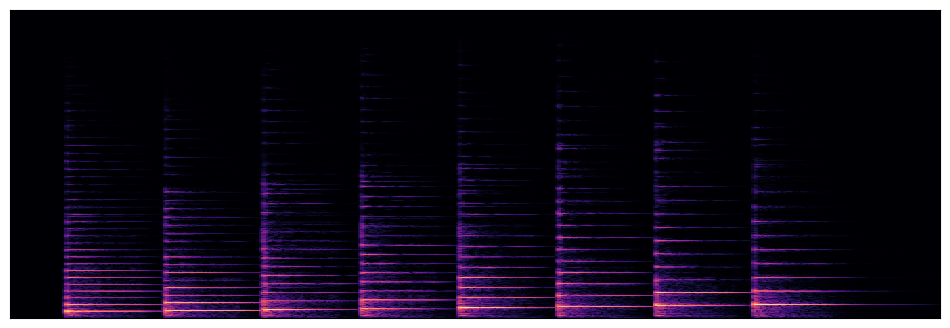

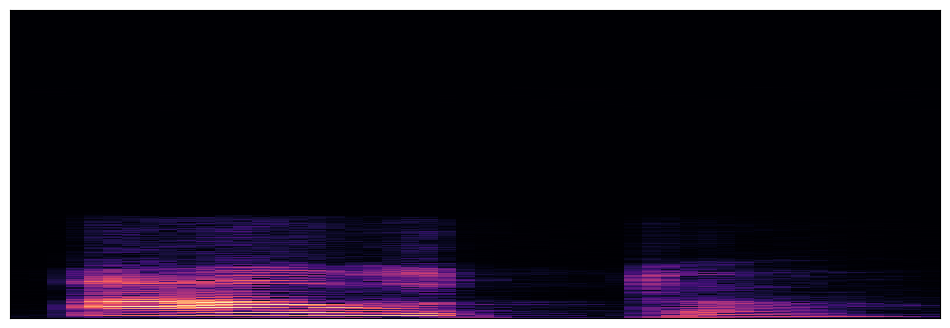

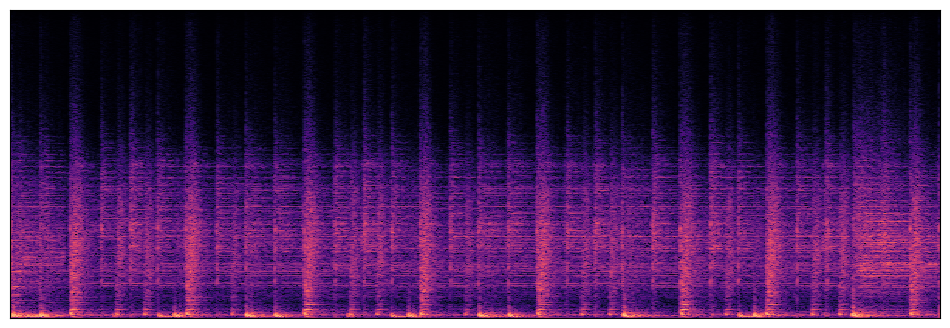

In [186]:
stft = {}

for key in y.keys():
    stft[key] = lr.stft(y=y[key])
    plt.figure(figsize=(12, 4))
    lr.display.specshow(np.log(1 + np.abs(stft[key]) * 10))
    plt.show()

## Zero Crossing Rate (ZCR)

The Zero Crossing Rate (ZCR) bezieht sich auf die Rate, mit der das Audiosignal das Vorzeichen wechselt (durch Null "crossed").

Die ZCR kann aus folgenden Gründen nützlich sein:
- **Einfach und schnell**: Die Berechnung ist rechnerisch relativ unaufwändig.
- **Andeutung von Rauschen und Klangfarbe**: Ein hoher ZCR-Wert entspricht oft geräuschhaften oder perkussiven Klängen (auch Konsonanten in Sprache). Ein niedriger ZCR-Wert ist eher typisch für tonale und harmonische Signale.
- **Nützlich für Klassifizierung**: Die ZCR kann helfen, Audiosignale zu klassifieren (z.B. Unterscheidung von Musik und Sprache; Genre-Klassifizierung; Instrument-Klassifizierung)

Berechnet und plottet von folgenden Audio-Files die ZCR:
- `amen-break`
- `speech`
- `piano-scale`

Achtet darauf, dass die y-Achse bei allen Plots gleich skaliert ist.

(Beobachtet, wie die verschiedenen Files die Werte der ZCR beeinflussen.)

p
(1, 444)


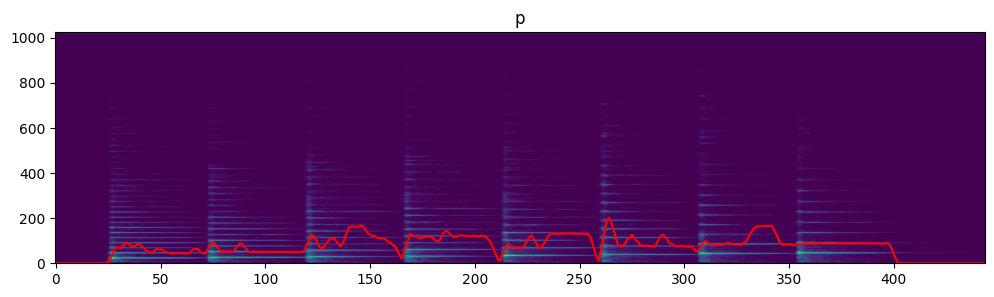

au
(1, 50)


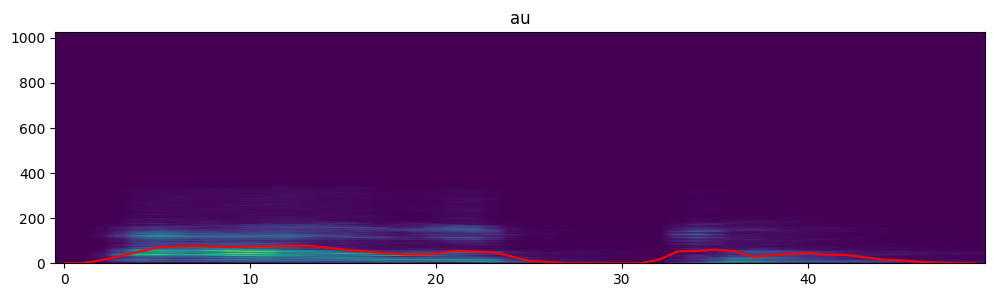

am
(1, 601)


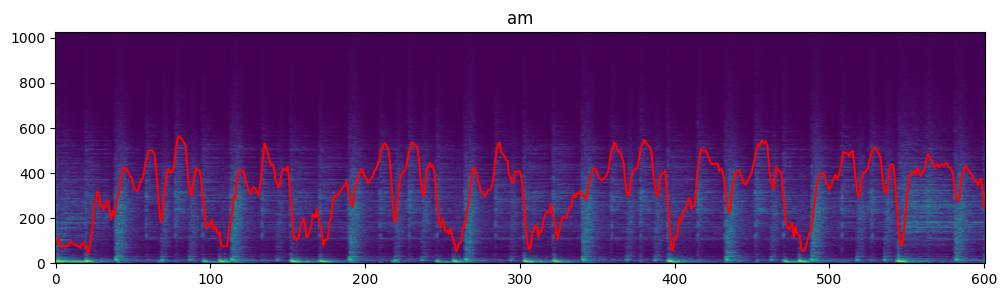

In [203]:
zcr = {}

for key in y.keys():
    print(key)
    zcr[key] = lr.feature.zero_crossing_rate(y=y[key] + 0.01)
    print(zcr[key].shape)

    plt.figure(figsize=(12, 3))
    plt.title(key)
    plt.imshow(np.log(1 + np.abs(stft[key])), aspect='auto', origin='lower')
    plt.plot(zcr[key][0] * 2000, 'r')
    plt.show()

## Temporal Centroid

**Temporal Centroid** ist ein Beispiel für ein Audio-Feature, das nur aus einem Wert besteht. Es stellt den "center of mass" der Amplituden-Envelope eines Klangs dar. Es ist also ein Maß dafür, wann die Energie eines Klangs im Laufe der Zeit am stärksten konzentriert ist.

Nützlichkeit des Features:
- **Charakterisierungn der Schallwahrnehmung**: Das Feature gibt einen Hinweis darauf, ob ein Klang "frontlastig" (= 'front-heavy') oder "rücklastig" ('back-heavy'), also mit früh oder spät konzentrierter Energie wahrgenommen wird.
- **Differentiating Sound Types**: It helps in distinguishing between different types of sounds or musical instruments, as they often have unique temporal characteristics.
- **Use in Music and Speech Analysis**: Temporal centroid is important in music analysis (e.g., identifying rhythmic patterns) and speech procesing (e.g., distinguishing between syllables).

Berechnung:

`librosa` stellt keine Funktion für den temporal centroid zur Verfügung. Wir können es aber basierend auf der Amplitudenhüllkurve des Klangs berechnen.

$${\displaystyle C_t = \frac{\sum_{n=1}^{N} n \cdot E(n)}{\sum_{n=1}^{N} E(n)}}$$

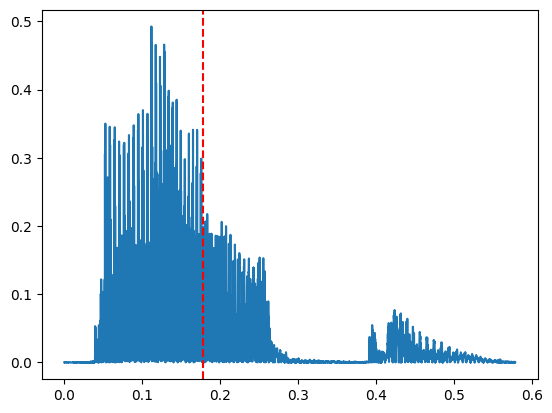

0.17825031352372245


In [207]:
envelope = np.abs(y['au'])
time = np.arange(0, len(envelope)) / sr['au']

temporal_centroid = sum(time * envelope) / sum(envelope)

plt.plot(time, envelope)
plt.axvline(x=temporal_centroid, color='r', linestyle='--')
plt.show()

print(temporal_centroid)

## Root-Mean-Square-Energy (RMS)

Die **Root Mean Square (RMS) Energy** beschreibt die durschnittliche Amplitude eines Audiosignals.

RMS korrelliert einigermaßen mit der menschlichen Wahrnehmung der Lautstärke eines Klangs.

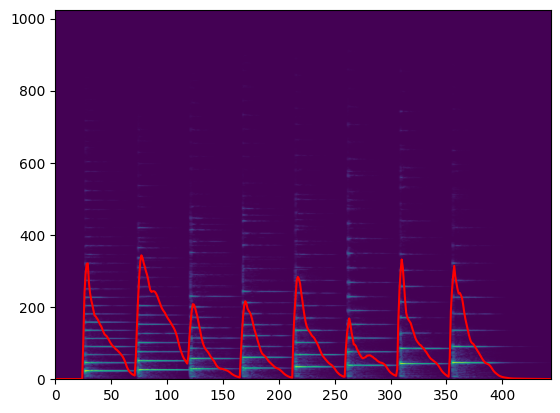

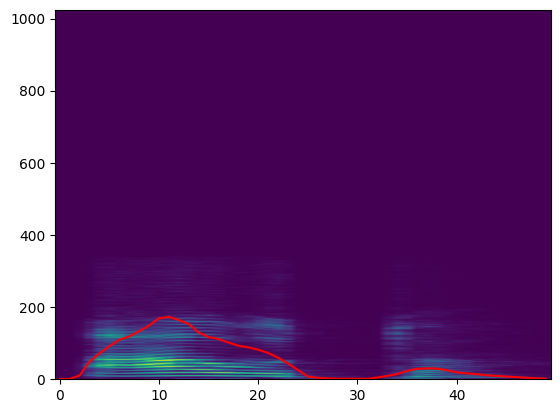

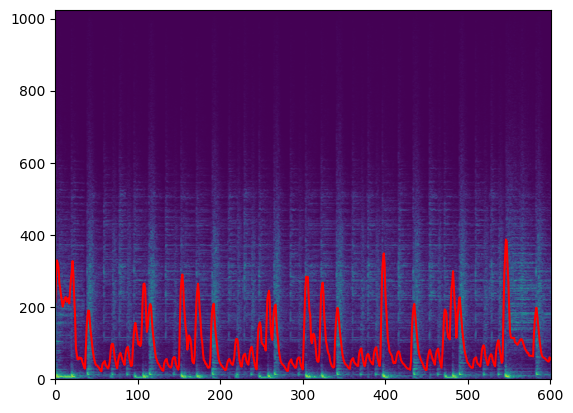

In [214]:
rms = {}

for key in y.keys():

    rms[key] = lr.feature.rms(y=y[key])

    plt.imshow(np.log(1 + np.abs(stft[key])), aspect='auto', origin='lower')
    plt.plot(rms[key][0] * 1000, 'r')
    plt.show()

## Energy Entropy

Das **Energy Entropy** Feature misst die Verteilung der Energie eines Audiosignals über die Zeit und bietet Einblicke in die Komplexität und Variablilität des Signals.

- **Komplexitäts- und Variabilitätsanalyse**: bietet einen Hinweis auf Regelmäßigkeiten (und Muster) in Audioaufnahmen.
- **Music Genre Classification**: das Feature wird manchmal für Music Genre Classification Szenarien verwendet.

`librosa` bietet zwar keine Funktion zur Berechnung, allerdings können wir die Energy Entropy recht einfach basierend auf der RMS-Energy berechnen:

$E = - \sum_{i = 1}^{N} p_i \log_2(p_i)$

In [ ]:
def calc_energy_entropy(y, frame_length=2048, hop_length=1024, k=10):

    energy_entropy = []

    # über frames iterieren
    for i in range(0, len(y), hop_length):
        frame = y[i:i+frame_length]
        sub_frame_length = int(len(frame) / k)
        e_short_frame = np.sum(frame ** 2)

        # normalisierte energie-werte in den sub-frames
        e_j = []
        for j in range(k):
            e_sub_frame = np.sum(frame[j * sub_frame_length : (j + 1) * sub_frame_length] ** 2)
            e_j.append(e_sub_frame / e_short_frame if e_short_frame > 0 else 0)

        # entropie für frames berechnen
        entropy = -np.sum([p * np.log2(p + np.finfo(float).eps) for p in e_j])
        energy_entropy.append(entropy)

    return np.array(energy_entropy)

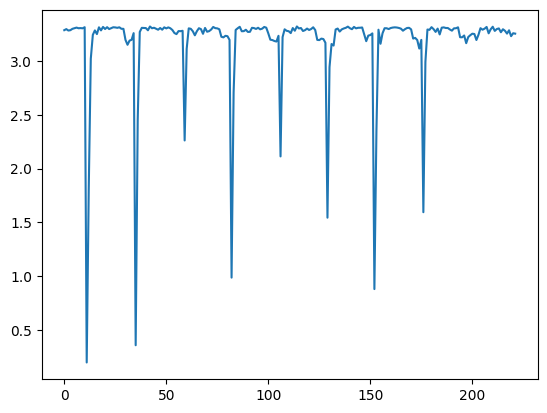

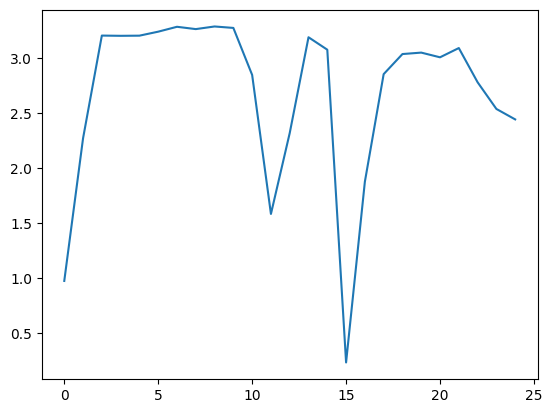

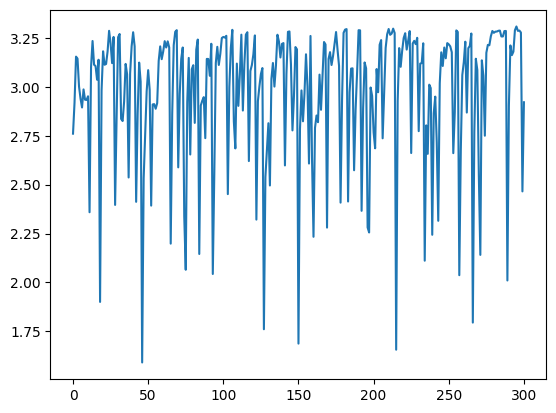

In [224]:
entropy = {}

for key in y.keys():
    entropy[key] = calc_energy_entropy(y[key])

    plt.plot(entropy[key])
    plt.show()

## Spectral Centroid

**Spectral Centroid** bestimmt den "Schwerpunkt" der Frequenzen in einem Klangspektrum, gewichtet nach deren Magnitude.

**Berechnung**:

$$C_s = \dfrac{\sum_i f_i \cdot y_i}{\sum_i y_i}$$

**Interpretation**:

Höhere Werte deuten auf "helle"/"schrille", und niedrige Werte auf "dunkle"/"milde" Klangfarben hin.

## Spectral Bandwidth

**Spectral Bandwidth** beschreibt die Breite des Frequenzspektrums eines Audiosignals. Es liefert Informationen darüber, wie sich die Energie im Signal über den Frquenzbereich um den *Spectral Centroid* herum verteilt.

**Berechnung**:

$$B_s = (\dfrac{\sum_i (f_i - C_s)^p \cdot y_i}{\sum_i y_i})^{\frac{1}{p}}$$ 
wobei $p$ die Ordnung der Bandbreite ist (meistens $p=2$).

**Interpretation**:

- Hohe Werte: breites Spektrum, viele Obertöne
- Niedrige Werte: enges / spitzes Spektrum (z.B. reine Sinuswellen)

## Spectral Rolloff

**Spectral Rolloff** gibt an, unter welcher Frequenz sich ein manuell angegebener Anteil (typischerweise ca. 80%) der Energie im Frequenzbereich befindet.

**Berechnung**:

$${C \sum_{k=0}^{N-1} X_n(k)}$$

**Interpretation**:

- Hohe Werte: größerer Anteil der Energie des Signals liegt in den höheren Frequenzen.
- Niedrige Werte: mehr Energie in den niedriegeren Frequenzen.

## Spectral Contrast

**Spectral Contrast** misst die Unterschiede zwishcen den Peaks und Valleys im Spektrum des Audiosignals.

**Interpretation**:

- Hohe Werte: Signal enthält klare und starke Frequenzkomponenten im Vergleich zu den umgebenden Frequenzen
- Niedrige Werte: Spektrum relativ gleichmäßig verteilt, ohne deutliche Spitzen und Täler.

## Spectral Flatness

**Spectral Flatness** gibt an, wie rausch- oder ton-ähnlich ein Signal ist. Je flacher, desto rauschartiger, und andersherum.

**Berechnung**:

$$\text{Flatness}_S = \frac{\left(\prod_{i=1}^{N} S(i)\right)^{\frac{1}{N}}}{\frac{1}{N}\sum_{i=1}^{N} S(i)}$$

## Spectral Entropy

**Spectral Entropy** ist ein Maß für die Unordnung/Gleichverteilugn der spektralen Energie im Audiosignal.

**Interpretation**:
- Hohe Werte: gleichmäßiges Spektrum (wie white noise)
- Niedrige Werte: wenige Frequenzbereiche (wie reine Töne)

**Berechnung**:

$$H = - \sum_{k = 1}^{N} p(k) \log_2 p(k)$$ wobei $p(k)$ die Wahrscheinlichkeit der Energie im $k$-ten Frequenzbin und $N$ die Gesamtzahl der Bins ist.

In [70]:
display(Audio(np.random.rand(44100 * 2) * 2 - 1, rate=44100))

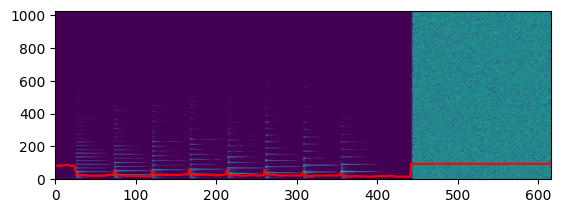

In [97]:
y, sr = lr.load('piano-scale.mp3', sr=None)

y = np.concatenate([y, np.random.rand(44100 * 2) * 2 - 1])

pow_stft = np.abs(lr.stft(y=y)) ** 2

spec_entropy = []

for frame in pow_stft.T:
    norm_spec = frame / np.sum(frame)
    epsilon = np.finfo(float).eps
    spectral_entropy_value = -np.sum(norm_spec * np.log2(norm_spec + epsilon))
    spec_entropy.append(spectral_entropy_value)

spec_entropy = np.array(spec_entropy)

plt.subplot(2, 1, 1)
plt.imshow(np.log10(1 + pow_stft), origin='lower', aspect='auto')
plt.plot(spec_entropy * 10, 'r')
plt.show()

## Chromagram

Das **Chromagramm** gruppert alle Noten der STFT in die zwölf verschiedenen Halbtöne unseres temperierten 12-tönigen Stimmungssystems.

- **Harmonische Analyse**: Chromagramme werden oft genutzt, um harmonische und melodische Eigenschaften eines Musikstücks zu analysieren. Sie sind Grundlage für das Erkennen von Akkorden, Tonarten und melodischen Mustern.
- **Musiktranskription**: Sie werden oft für die automatische Musiktranskription (ATM) verwendet, um Noten oder Akkorde aus einem Signal zu extrahieen.

(12, 616)


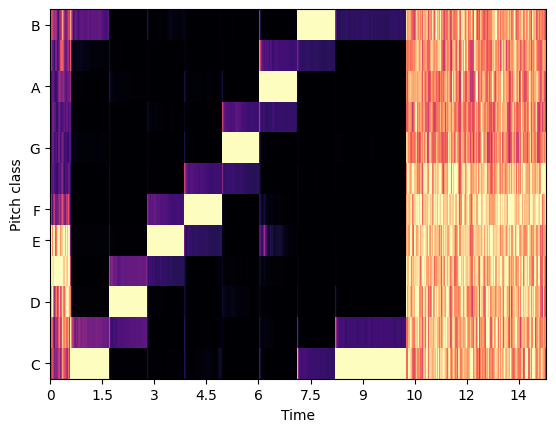

In [98]:
chroma = lr.feature.chroma_stft(y=y, sr=sr)
print(chroma.shape)

lr.display.specshow(chroma, y_axis='chroma', x_axis='time')

## Mel-Spectrogram

Beim **Mel-Spektrogramm** wird die Frequenzskale der STFT auf die [Mel-Skala](https://en.wikipedia.org/wiki/Mel_scale) umgerechnet.

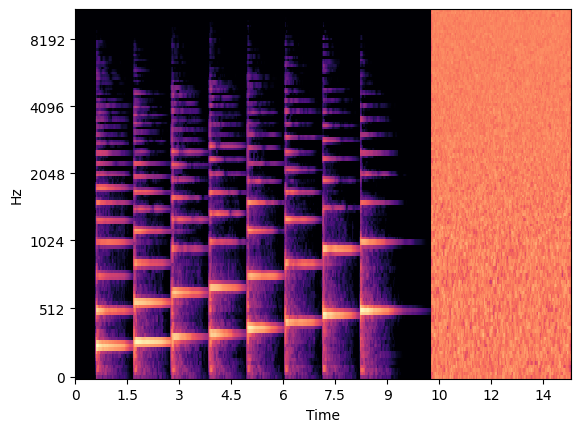

In [105]:
mel_spec = lr.feature.melspectrogram(y=y, sr=sr)

lr.display.specshow(lr.power_to_db(mel_spec, ref=np.max), y_axis='mel', x_axis='time')

## Mel-Frequency-Scaled Cepstral Coefficients (MFCCs)

**MFCCs** basieren auf dem Mel-Spektrogramm, dessen Magnituden in eine logarithmische Skala umgewandelt werden. Danach wird noch eine Diskrete Kosinus-Transformation (DCT) durchgeführt.

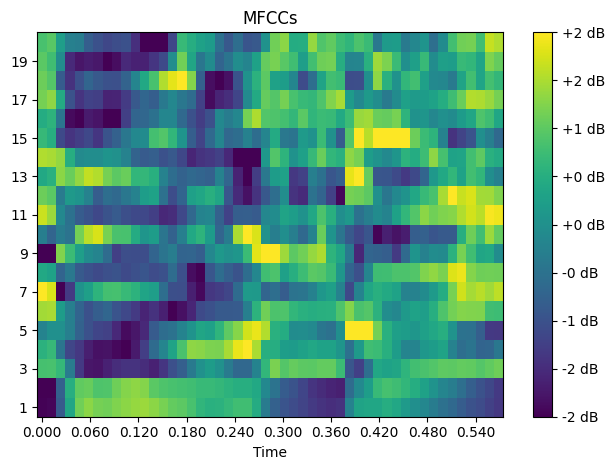

In [226]:
y_s, sr_s = lr.load('auto.mp3', sr=None)

mfccs = lr.feature.mfcc(y=y_s, sr=sr_s, n_mfcc=20)
mfccs = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / np.std(mfccs, axis=1, keepdims=True)

lr.display.specshow(mfccs, sr=sr_s, x_axis='time', cmap='viridis', vmin=-2, vmax=2)
mfcc_indices = np.arange(0, mfccs.shape[0], 2)
plt.yticks(mfcc_indices, [f'{i+1}' for i in mfcc_indices])
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.tight_layout()
plt.show()